In [ ]:
!pip install yahoo-fin

In [ ]:
!pip install requests_html

In [3]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si
from yahoo_fin import options

In [7]:
website_url = 'https://finviz.com/quote.ashx?t='
company_tikcers = ['AMD', 'AMZN', 'FB', 'GOOG']

In [8]:
news_tables = {}

for ticker in company_tikcers:
  url = website_url + ticker

  req = Request(url=url, headers={'user-agent': 'my-scrape'})
  response = urlopen(req)
  html = BeautifulSoup(response, 'html')
  news_data = html.find(id='news-table')
  news_tables[ticker] = news_data

In [9]:
parsed_data = []

for ticker, news_table in news_tables.items():
  for row in news_table.findAll('tr'):
    title = row.a.text
    date_data = row.td.text.split(' ')

    if len(date_data) == 1:
      time = date_data[0][0:7]
    else:
      date = datetime.datetime.strptime(date_data[0], '%b-%d-%y').strftime('%Y/%m/%d')
      time = date_data[1][0:7]

    parsed_data.append([ticker, date, time, title])

In [ ]:
parsed_data

In [11]:
dataset = pd.DataFrame(parsed_data, columns=["Company", "Date", "Time", "News Headline"])
dataset.to_csv('CompanyNewsHeadlines_WithoutSentiment.csv', index=False)
dataset.head()

,Company,Date,Time,News Headline
0,AMD,2020/11/17,06:30AM,"Intel May Be Down, But It's Far From Being Out"
1,AMD,2020/11/16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...
2,AMD,2020/11/16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...
3,AMD,2020/11/16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...
4,AMD,2020/11/16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage


In [12]:
sia=SentimentIntensityAnalyzer()

dataset['Compound'] = dataset['News Headline'].apply(lambda headline: sia.polarity_scores(headline)['compound'])

In [13]:
def sentiment_declareation(sentiment_value):
  if -0.2 < sentiment_value <= 0.2:
      return 'neu'
  elif 0.2 < sentiment_value <= 1.0:
      return 'pos'
  elif -1.0 <= sentiment_value <= -0.2:
      return 'neg'

In [14]:
dataset['Sentiment'] = dataset['Compound'].apply(lambda value: sentiment_declareation(value))

In [15]:
dataset['Date'] = pd.to_datetime(dataset.Date).dt.date

In [16]:
dataset.head()

,Company,Date,Time,News Headline,Compound,Sentiment
0,AMD,2020-11-17,06:30AM,"Intel May Be Down, But It's Far From Being Out",0.0000,neu
1,AMD,2020-11-16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...,-0.5574,neg
2,AMD,2020-11-16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...,0.3818,pos
3,AMD,2020-11-16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...,0.0000,neu
4,AMD,2020-11-16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage,0.2500,pos


In [17]:
dataset.to_csv('CompanyNewsHeadlines.csv', index=False)

In [18]:
max_min_date = dataset.groupby(['Company']).agg({'Date': [np.min,np.max]})
max_min_date

Date            
               amin        amax
Company                        
AMD      2020-10-27  2020-11-17
AMZN     2020-11-12  2020-11-17
FB       2020-11-06  2020-11-17
GOOG     2020-11-10  2020-11-17

In [19]:
dataset['MaxDate'] = dataset.groupby('Company').Date.transform('max')
dataset['MinDate'] = dataset.groupby('Company').Date.transform('min')

dataset.head()

,Company,Date,Time,News Headline,Compound,Sentiment,MaxDate,MinDate
0,AMD,2020-11-17,06:30AM,"Intel May Be Down, But It's Far From Being Out",0.0000,neu,2020-11-17,2020-10-27
1,AMD,2020-11-16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...,-0.5574,neg,2020-11-17,2020-10-27
2,AMD,2020-11-16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...,0.3818,pos,2020-11-17,2020-10-27
3,AMD,2020-11-16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...,0.0000,neu,2020-11-17,2020-10-27
4,AMD,2020-11-16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage,0.2500,pos,2020-11-17,2020-10-27


In [20]:
company_early_late_dates = {}

for index, row in dataset.iterrows():
  if row['Company'] in company_early_late_dates:
      company_early_late_dates[row['Company']]['early'] = row['MinDate']
      company_early_late_dates[row['Company']]['late'] = row['MaxDate']
  else:
    company_early_late_dates[row['Company']] = {'early': None, 'late': None}

company_early_late_dates

{'AMD': {'early': datetime.date(2020, 10, 27),
  'late': datetime.date(2020, 11, 17)},
 'AMZN': {'early': datetime.date(2020, 11, 12),
  'late': datetime.date(2020, 11, 17)},
 'FB': {'early': datetime.date(2020, 11, 6),
  'late': datetime.date(2020, 11, 17)},
 'GOOG': {'early': datetime.date(2020, 11, 10),
  'late': datetime.date(2020, 11, 17)}}

In [21]:
for key, value in company_early_late_dates.items():
  print(key, '->', value)
  tmp_df = si.get_data(key, start_date=value['early'], end_date=value['late'])
  tmp_df['date'] = tmp_df.index
  tmp_df.to_csv(key + '_NLTK.csv', index=False)

AMD -> {'early': datetime.date(2020, 10, 27), 'late': datetime.date(2020, 11, 17)}
AMZN -> {'early': datetime.date(2020, 11, 12), 'late': datetime.date(2020, 11, 17)}
FB -> {'early': datetime.date(2020, 11, 6), 'late': datetime.date(2020, 11, 17)}
GOOG -> {'early': datetime.date(2020, 11, 10), 'late': datetime.date(2020, 11, 17)}


In [22]:
sentiment_result = {}
for value in dataset['Sentiment']:
  if value in sentiment_result:
    if value == 'neu':
      sentiment_result['neu'] += 1
    elif value == 'pos':
      sentiment_result['pos'] += 1
    elif value == 'neg':
      sentiment_result['neg'] += 1
  else:
    sentiment_result[value] = 1

sentiment_result

{'neg': 58, 'neu': 218, 'pos': 124}

In [23]:
result_by_companies = {}
for index, row in dataset.iterrows():
  if row['Company'] in result_by_companies:
    if row['Sentiment'] == 'neu':
      result_by_companies[row['Company']]['neu'] +=1
    if row['Sentiment'] == 'pos':
      result_by_companies[row['Company']]['pos'] +=1
    if row['Sentiment'] == 'neg':
      result_by_companies[row['Company']]['neg'] +=1
  else:
    result_by_companies[row['Company']] = {'neg': 0, 'neu': 0, 'pos': 0}

result_by_companies

{'AMD': {'neg': 10, 'neu': 47, 'pos': 42},
 'AMZN': {'neg': 12, 'neu': 55, 'pos': 32},
 'FB': {'neg': 22, 'neu': 54, 'pos': 23},
 'GOOG': {'neg': 14, 'neu': 59, 'pos': 26}}

In [24]:
dataframe_list = []
for key, value in result_by_companies.items():
  print(key, '->', value)
  dataframe_list.append([key, value['neg'], value['neu'], value['pos']])


dataset_company = pd.DataFrame(dataframe_list, columns=["Company", "Neg", "Neu", "Pos"])
dataset_company.head()

AMD -> {'neg': 10, 'neu': 47, 'pos': 42}
AMZN -> {'neg': 12, 'neu': 55, 'pos': 32}
FB -> {'neg': 22, 'neu': 54, 'pos': 23}
GOOG -> {'neg': 14, 'neu': 59, 'pos': 26}


,Company,Neg,Neu,Pos
0,AMD,10,47,42
1,AMZN,12,55,32
2,FB,22,54,23
3,GOOG,14,59,26


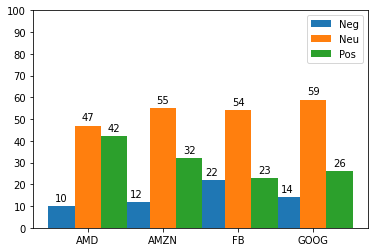

In [25]:
index = np.arange(len(company_tikcers))
score_label = np.arange(0, 110, 10)

bar_width = 0.35

fig, ax = plt.subplots()
barNeg = ax.bar(index - bar_width, dataset_company['Neg'], bar_width, label='Neg')
barNeu = ax.bar(index, dataset_company['Neu'], bar_width, label='Neu')
barPos = ax.bar(index + bar_width, dataset_company['Pos'], bar_width, label='Pos')

ax.set_xticks(index)
ax.set_xticklabels(company_tikcers)

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)


ax.legend()

def insert_data_labels(bars):
  for bar in bars:
    bar_height = bar.get_height()
    ax.annotate('{0:.0f}'.format(bar.get_height()),
                xy=(bar.get_x() + bar.get_width() / 2, bar_height),
                xytext=(0,3),
                textcoords='offset points',
                ha='center',
                va='bottom'
    )

insert_data_labels(barNeg)
insert_data_labels(barNeu)
insert_data_labels(barPos)

plt.show()

In [28]:
mean_df = dataset.groupby(['Company', 'Date']).mean()

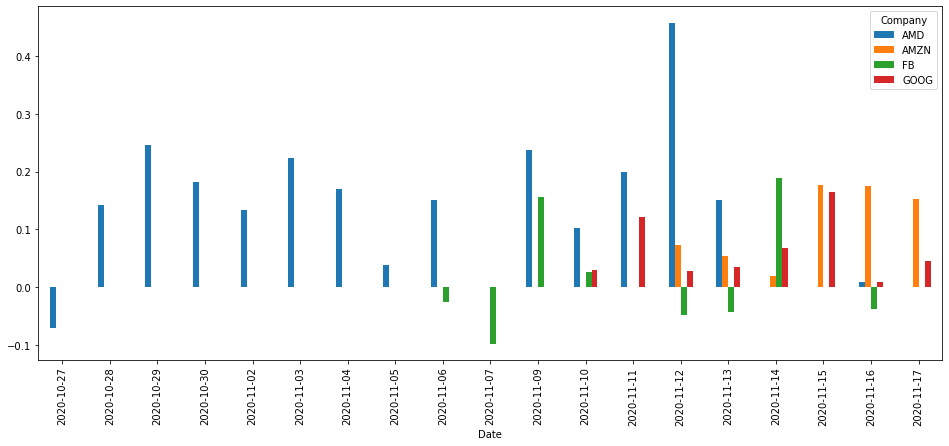

In [29]:
mean_df = mean_df.unstack()
mean_df = mean_df.xs('Compound', axis='columns').transpose()
mean_df.plot(kind='bar', figsize=(16.2, 6.5))

In [30]:
def percentage(part, whole):
  temp = 100 * float(part) / float(whole)
  return format(temp, '.2f')

In [31]:
def visualization(positive, neutral, negative):
  labels = ['Positive [' + str(positive) + '%]','Neutral [' + str(neutral) + '%]',
            'Negative [' + str(negative) + '%]']
  sizes = [positive, neutral, negative]
  colors = ['lightgreen', 'gold', 'red']
  patches, texts = plt.pie(sizes, colors=colors, startangle=90)
  plt.title('Aggregate sentiment value of the economic news headlines')
  plt.legend(patches, labels, loc="best")
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

In [32]:
def company_specific_sentiment_visualization(company_name):
  company_df = dataset[dataset['Company'] == company_name]
  temp = company_df.groupby(['Company', 'Date']).mean()
  temp= temp.unstack()
  temp = temp.xs('Compound', axis='columns').transpose()
  temp.plot(kind='line', figsize=(16.2, 6.5))

In [33]:
def company_specific_sentiment_and_stockclose_day_focus_visualization(company_name, company_stock_dataframe):
  company_specific = dataset[dataset['Company'] == company_name]
  temp_company = company_specific.groupby(['Company', 'Date']).mean()
  temp_company.to_csv(company_name + '_SentimentAndValueOnDays.csv')

  temp_dataframe = pd.read_csv("/content/" + company_name + "_SentimentAndValueOnDays.csv")
  temp_dataframe['adjclose'] = temp_dataframe.Date.map(company_stock_dataframe.set_index('date')['adjclose'].to_dict())
  temp_dataframe = temp_dataframe.dropna(subset=['adjclose'])
  return temp_dataframe

In [34]:
def company_compound_adjclose_normalized(company_name, company_combinated_dataframe):
  normalized_df=(company_combinated_dataframe-company_combinated_dataframe.mean())/company_combinated_dataframe.std()

  plt.figure(figsize=(16.2, 6.5))
  plt.title(company_name + ': Normalized AdjClose values with Compounds')
  plt.plot(company_combinated_dataframe['Date'], normalized_df['Compound'], label='compound')
  plt.plot(company_combinated_dataframe['Date'], normalized_df['adjclose'], label='adjclose')
  plt.xticks(rotation=70)
  plt.xlabel('Date')
  plt.ylabel('Compound')
  plt.legend()
  plt.show()

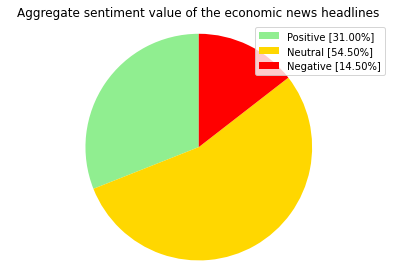

In [35]:
# össze gazdasági megítélés ezen cégek híreire fókuszálva
all_num = sentiment_result['pos'] + sentiment_result['neu'] + sentiment_result['neg']
pos_percent = percentage(part=sentiment_result['pos'], whole=all_num)
neu_percent = percentage(part=sentiment_result['neu'], whole=all_num)
neg_percent = percentage(part=sentiment_result['neg'], whole=all_num)

visualization(positive=pos_percent,neutral=neu_percent, negative=neg_percent)

In [36]:
amd_stock = pd.read_csv("/content/AMD_NLTK.csv")
amzn_stock = pd.read_csv("/content/AMZN_NLTK.csv")
fb_stock = pd.read_csv("/content/FB_NLTK.csv")
goog_stock = pd.read_csv("/content/GOOG_NLTK.csv")

In [37]:
def company_corr(company_stock, company_combinated_dataframe):
  company_data = company_combinated_dataframe.merge(company_stock, on='adjclose')
  company_data.drop(['ticker', 'date'], axis=1, inplace=True)
  company_data.rename(columns = {'Compound_x':'Compound'}, inplace = True) 

  plt.figure(figsize=(16, 10))
  sns.heatmap(company_data[['open', 'low', 'high', 'adjclose', 'Compound', 'volume']].corr(), annot=True)
  plt.show()

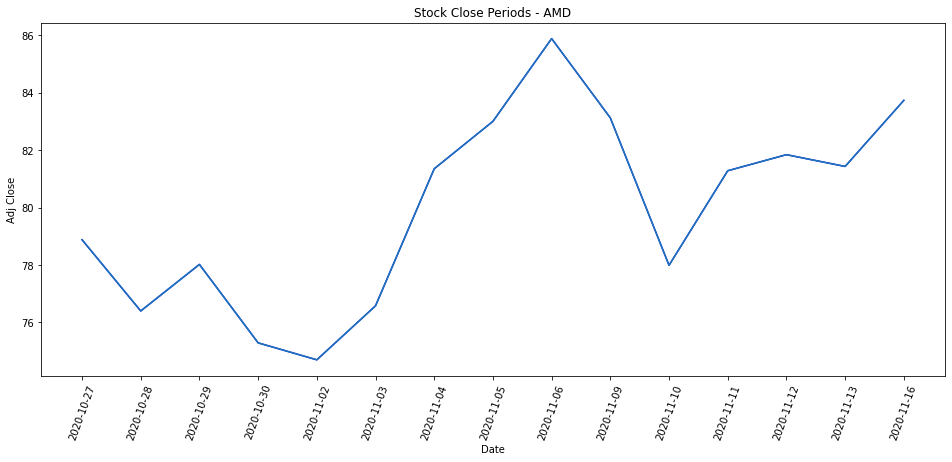

In [39]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - AMD')
plt.plot(amd_stock['adjclose'], label='AMD', color = 'blue')
x = amd_stock['date']
y = amd_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

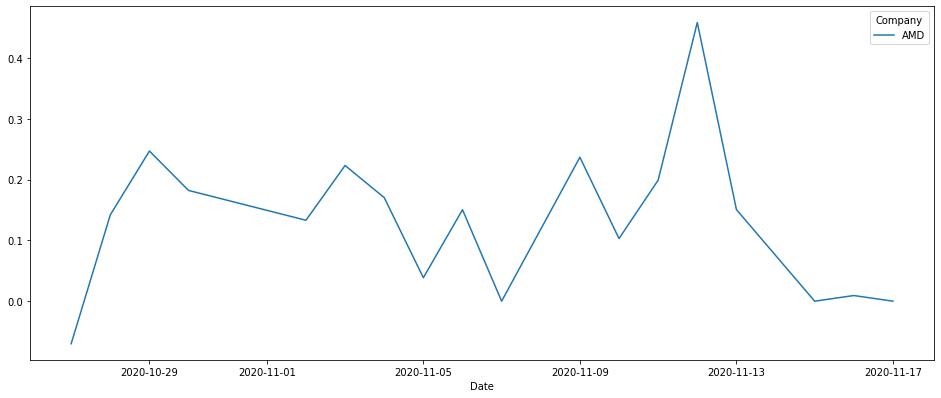

In [40]:
company_specific_sentiment_visualization('AMD')

In [41]:
AMD_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('AMD', amd_stock)
AMD_combinated_dataframe.head()

,Company,Date,Compound,adjclose
0,AMD,2020-10-27,-0.070038,78.879997
1,AMD,2020-10-28,0.142025,76.400002
2,AMD,2020-10-29,0.247060,78.019997
3,AMD,2020-10-30,0.182243,75.290001
4,AMD,2020-11-02,0.133160,74.699997


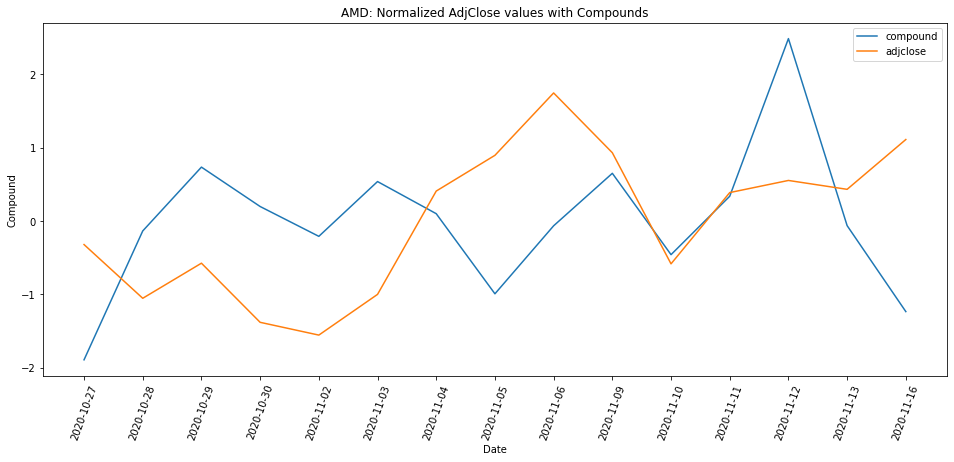

In [42]:
company_compound_adjclose_normalized('AMD', AMD_combinated_dataframe)

In [43]:
Timeseries_AMD = AMD_combinated_dataframe
Timeseries_AMD.index = Timeseries_AMD['Date']
Timeseries_AMD = Timeseries_AMD.drop('Date', 1)
Timeseries_AMD.groupby(['Company', 'Date'])
Timeseries_AMD.head()

,Company,Compound,adjclose
Date,,,
2020-10-27,AMD,-0.070038,78.879997
2020-10-28,AMD,0.142025,76.400002
2020-10-29,AMD,0.247060,78.019997
2020-10-30,AMD,0.182243,75.290001
2020-11-02,AMD,0.133160,74.699997


In [44]:
Timeseries_AMD['adjclose'].to_csv('Timeseries_AMD_adjclose.csv')
Timeseries_AMD['Compound'].to_csv('Timeseries_AMD_compound.csv')

In [45]:
AMD_normalized_df=(AMD_combinated_dataframe[['Compound', 'adjclose']]-AMD_combinated_dataframe[['Compound', 'adjclose']].mean())/AMD_combinated_dataframe[['Compound', 'adjclose']].std()
AMD_normalized_df

,Compound,adjclose
Date,,
2020-10-27,-1.893897,-0.321002
2020-10-28,-0.135197,-1.054042
2020-10-29,0.735891,-0.575202
2020-10-30,0.198342,-1.382138
2020-11-02,-0.208717,-1.556532
2020-11-03,0.538842,-1.000838
2020-11-04,0.100333,0.409084
2020-11-05,-0.992932,0.896794
2020-11-06,-0.064911,1.748067


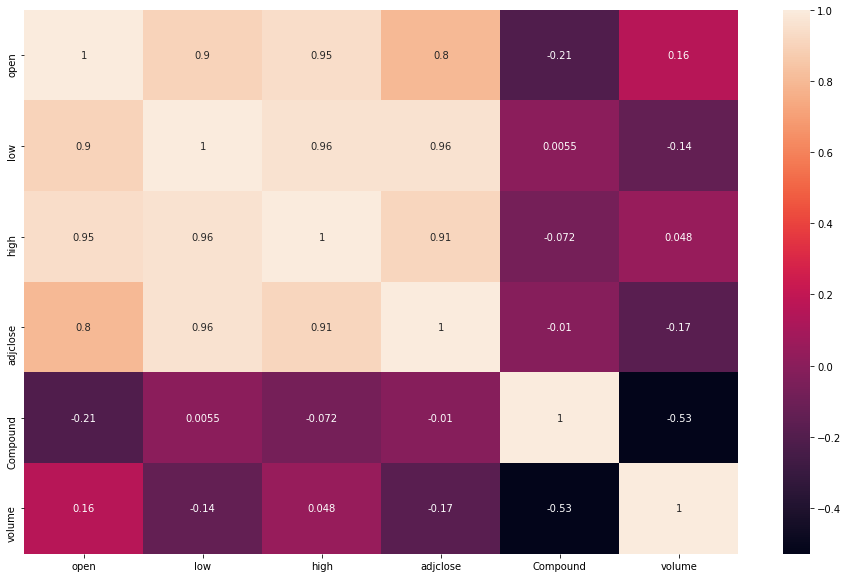

In [46]:
company_corr(amd_stock, AMD_combinated_dataframe)
# (Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day.)

In [47]:
AMD_adjclose_series = pd.read_csv('Timeseries_AMD_adjclose.csv', index_col=[0], parse_dates=True, squeeze=True)
# type(AMD_adjclose_series)
AMD_adjclose_series

Date
2020-10-27    78.879997
2020-10-28    76.400002
2020-10-29    78.019997
2020-10-30    75.290001
2020-11-02    74.699997
2020-11-03    76.580002
2020-11-04    81.349998
2020-11-05    83.000000
2020-11-06    85.879997
2020-11-09    83.120003
2020-11-10    77.989998
2020-11-11    81.279999
2020-11-12    81.839996
2020-11-13    81.430000
2020-11-16    83.730003
Name: adjclose, dtype: float64

In [48]:
AMD_adjclose_series.describe()

count    15.000000
mean     79.965999
std       3.383164
min      74.699997
25%      77.285000
50%      81.279999
75%      82.419998
max      85.879997
Name: adjclose, dtype: float64

In [53]:
pd.options.display.float_format = '{:,.3f}'.format
amd_stock.corr()

,open,high,low,close,adjclose,volume
open,1.000,0.946,0.902,0.800,0.800,0.159
high,0.946,1.000,0.962,0.911,0.911,0.048
low,0.902,0.962,1.000,0.963,0.963,-0.140
close,0.800,0.911,0.963,1.000,1.000,-0.172
adjclose,0.800,0.911,0.963,1.000,1.000,-0.172
volume,0.159,0.048,-0.140,-0.172,-0.172,1.000


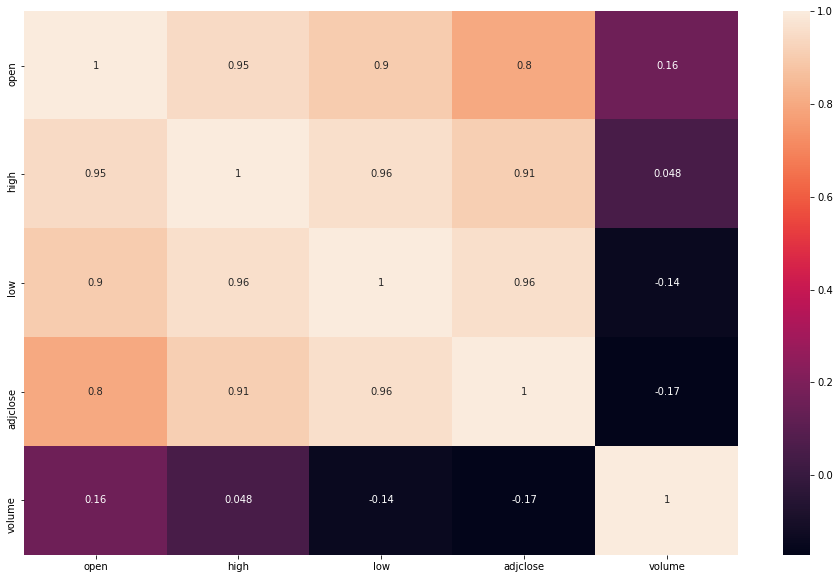

In [54]:
plt.figure(figsize=(16, 10))
sns.heatmap(amd_stock[['open', 'high', 'low', 'adjclose', 'volume']].corr(), annot=True)
plt.show()

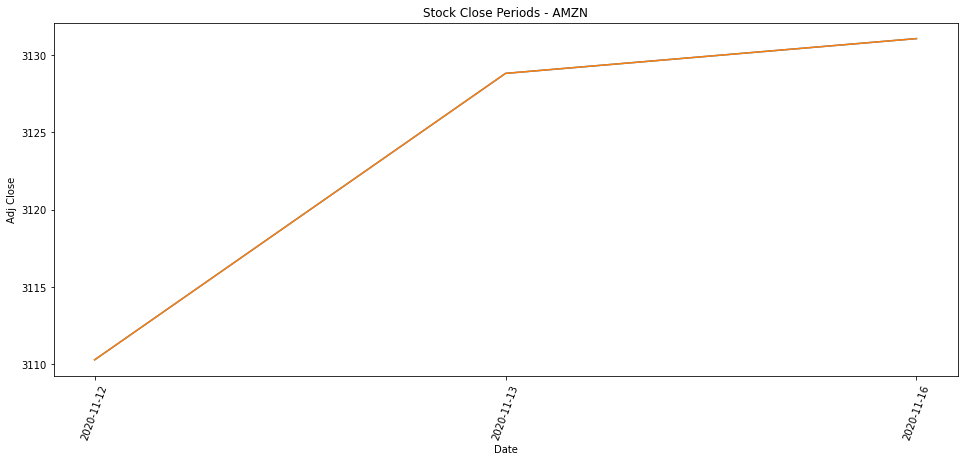

In [55]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - AMZN')
plt.plot(amzn_stock['adjclose'])
x = amzn_stock['date']
y = amzn_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

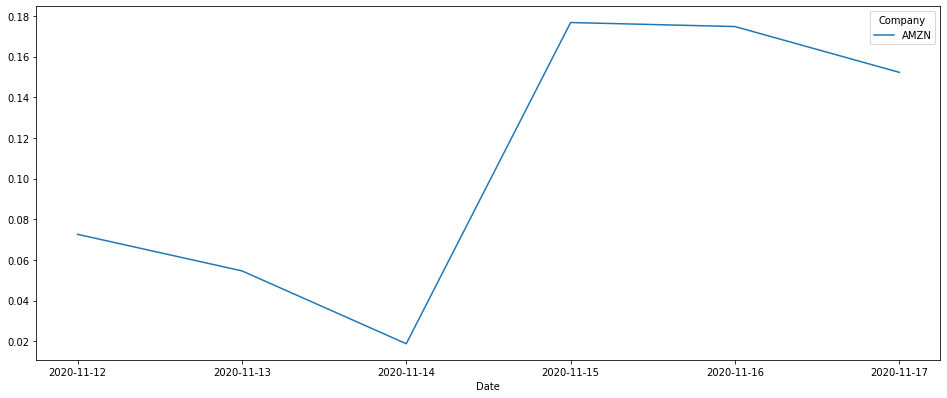

In [56]:
company_specific_sentiment_visualization('AMZN')

In [57]:
AMZN_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('AMZN', amzn_stock)
AMZN_combinated_dataframe.head()

,Company,Date,Compound,adjclose
0,AMZN,2020-11-12,0.073,"3,110.280"
1,AMZN,2020-11-13,0.055,"3,128.810"
4,AMZN,2020-11-16,0.175,"3,131.060"


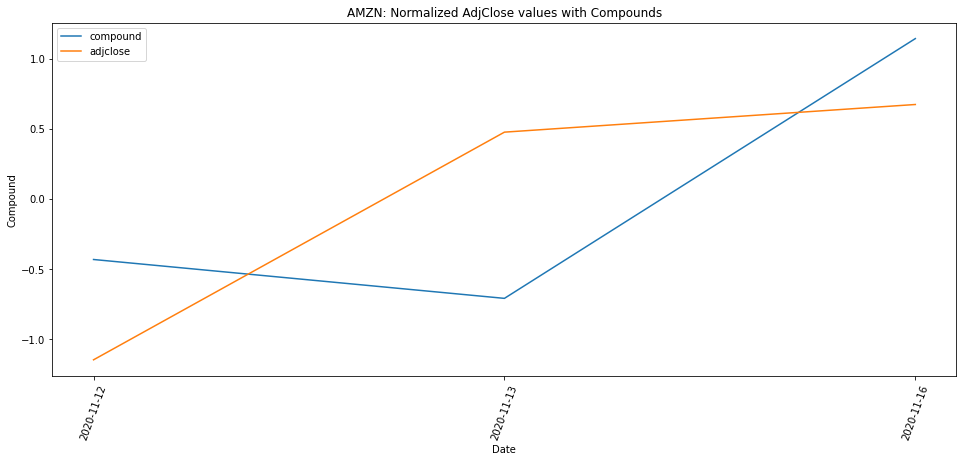

In [58]:
company_compound_adjclose_normalized('AMZN', AMZN_combinated_dataframe)

In [ ]:
company_corr(amzn_stock, AMZN_combinated_dataframe)

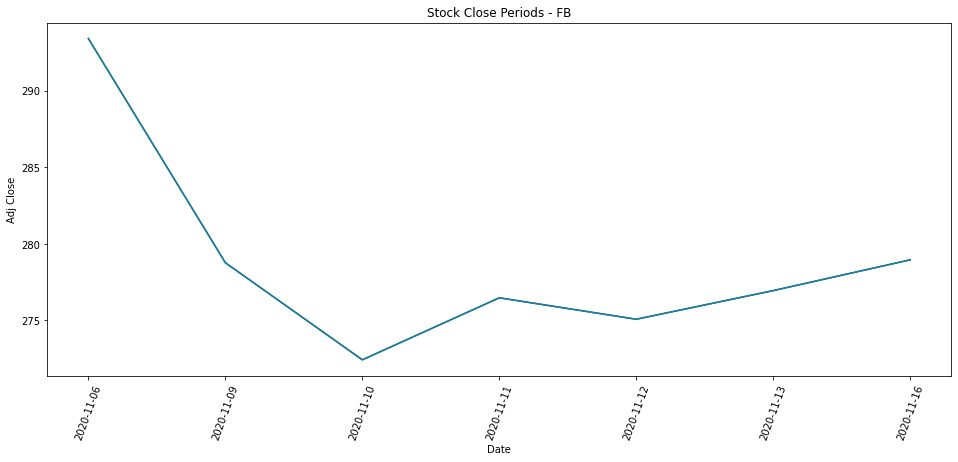

In [62]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - FB')
plt.plot(fb_stock['adjclose'], label='FB', color = 'green')
x = fb_stock['date']
y = fb_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

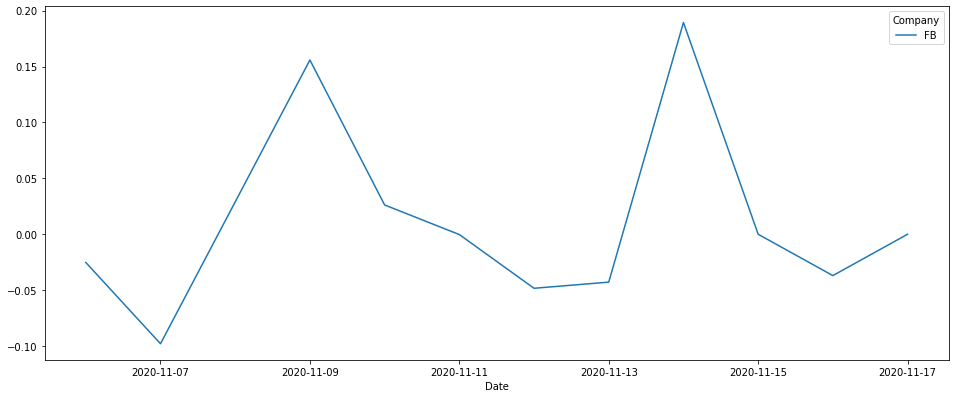

In [63]:
company_specific_sentiment_visualization('FB')

In [64]:
FB_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('FB', fb_stock)
FB_combinated_dataframe.head()

,Company,Date,Compound,adjclose
0,FB,2020-11-06,-0.025,293.410
2,FB,2020-11-09,0.156,278.770
3,FB,2020-11-10,0.026,272.430
4,FB,2020-11-11,-0.000,276.480
5,FB,2020-11-12,-0.048,275.080


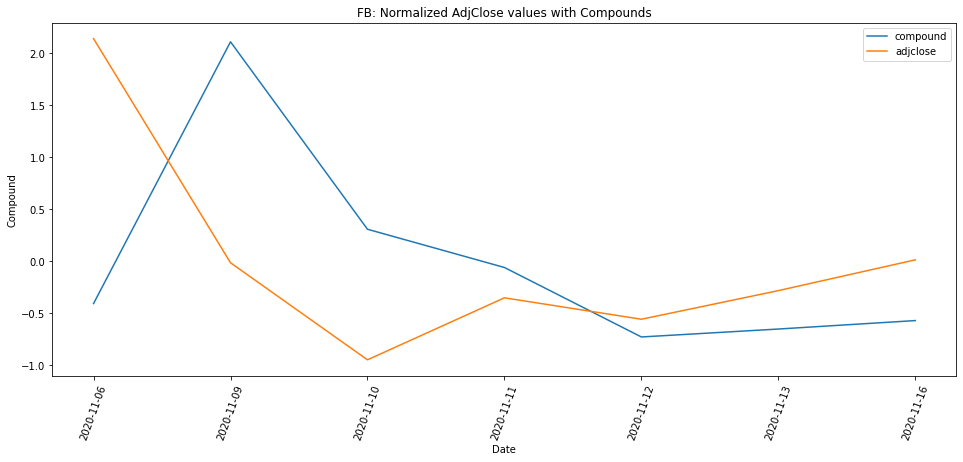

In [65]:
company_compound_adjclose_normalized('FB', FB_combinated_dataframe)

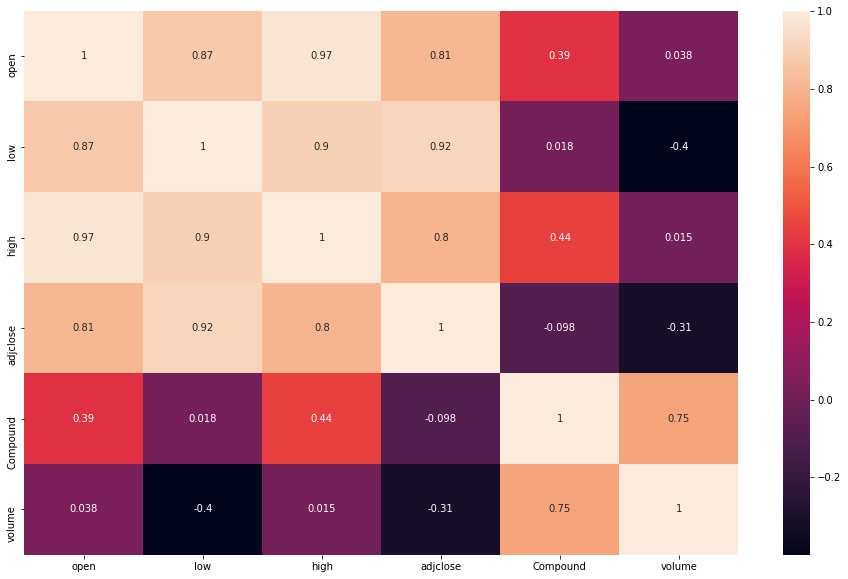

In [66]:
company_corr(fb_stock, FB_combinated_dataframe)

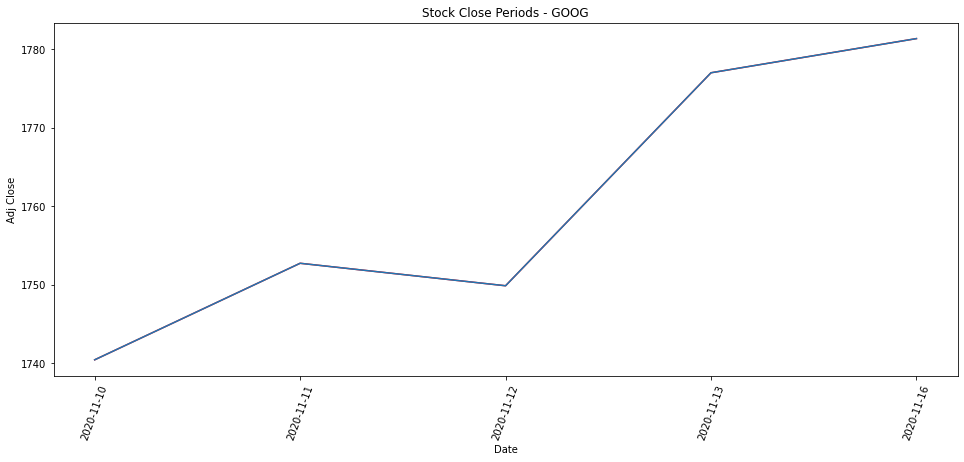

In [67]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - GOOG')
plt.plot(goog_stock['adjclose'], label='GOOG', color = 'red')
x = goog_stock['date']
y = goog_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

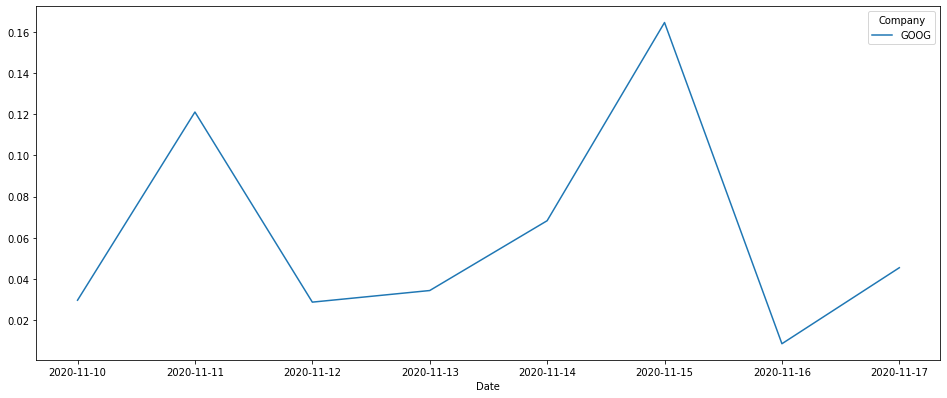

In [68]:
company_specific_sentiment_visualization('GOOG')

In [69]:
GOOG_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('GOOG', goog_stock)
GOOG_combinated_dataframe.head()

,Company,Date,Compound,adjclose
0,GOOG,2020-11-10,0.030,"1,740.390"
1,GOOG,2020-11-11,0.121,"1,752.710"
2,GOOG,2020-11-12,0.029,"1,749.840"
3,GOOG,2020-11-13,0.034,"1,777.020"
6,GOOG,2020-11-16,0.009,"1,781.380"


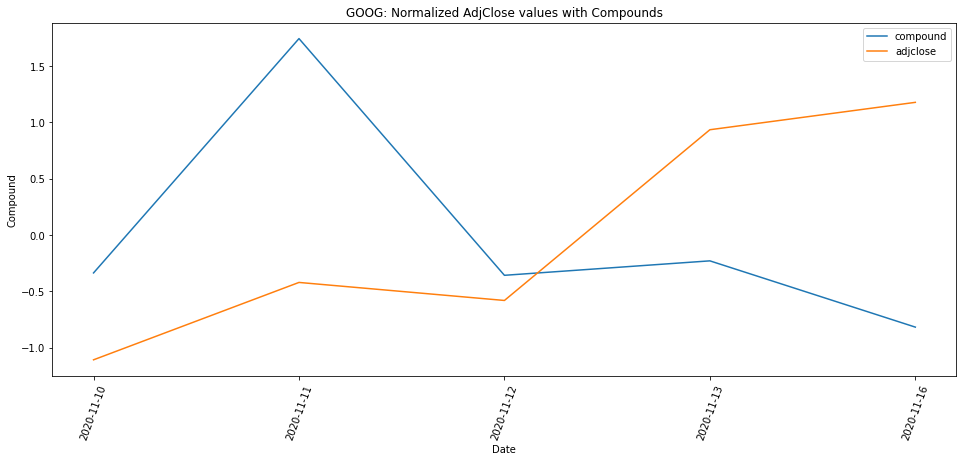

In [70]:
company_compound_adjclose_normalized('GOOG', GOOG_combinated_dataframe)

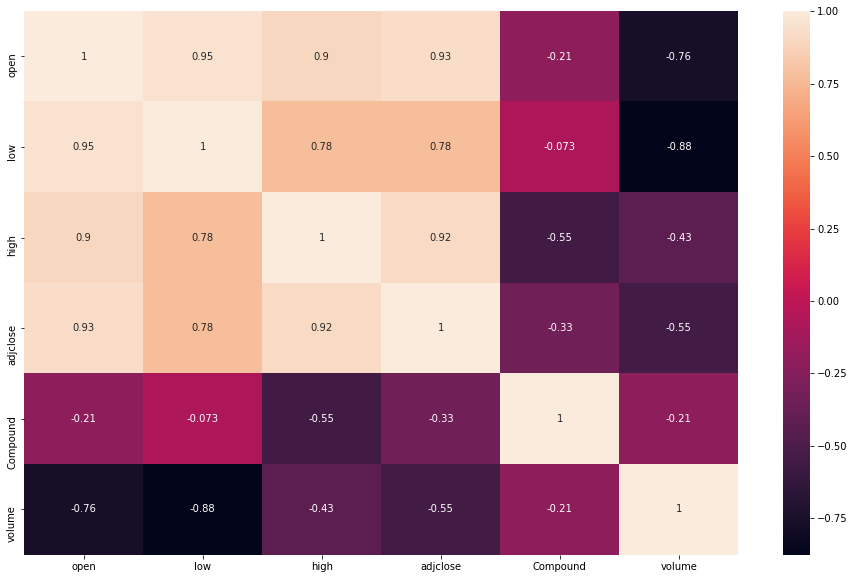

In [71]:
company_corr(goog_stock, GOOG_combinated_dataframe)